# Notebook to generate a pandas DataFrame containing data across mosquitoes

NB: At the moment, I think it will be useful to have two data frames:
1. A fly level data frame that can be used for e.g. wbf vs spike rate plots
2. A burst level data frame used for comparison of spike numbers, etc
   

## Imports

In [1]:
import os 
import glob
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
from scipy import signal
from mosquito.process_abf import load_processed_data
from mosquito.analyze_bursts import detect_burst_peaks


## Params

In [2]:
# path to data
data_root = '/media/sam/SamData/Mosquitoes'

# species to look at?
species = 'aedes'

# where to save datraframe to 
save_flag = False
save_path = os.path.join(data_root, 'analysis')

# path to log file (and load)
log_path = os.path.join(data_root, 'experiment_log.xlsx')
log_df = pd.read_excel(log_path)


In [3]:
# list of data files to grab (given as (Expr number).(axo number))
if species == 'aedes':
    data_files = [19.1, 19.2, 19.4, 19.5, 19.6,
                  22.0, 22.1, 22.2, 22.4, 22.5, 22.6, 22., 22.8, 22.9, 22.12,
                  23.0, 23.1, 23.2, 23.3, 23.4, 23.5, 23.6, 
                  24.7, 24.8, 
                  26.1, 26.2, 26.3, 
                  28.0, 28.1, 28.2, 28.5, 28.6, 28.8, 28.9, 
                  29.7, 29.8]
    save_name = 'mosquito'

elif species == 'drosophila':
    data_files = [18.0, 18.1, 27.5, 30.0, 30.1, 30.2, 31.3, 31.4, 31.5, 31.6]
    save_name = 'drosophila'


In [4]:
# plot params
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


## Helper functions

In [5]:
def bin_time_series(dat, bin_width=65536, groupby_func='mean'):
    """
    Function to bin data like wingbeat frequency or spike rate, as these are made 
    continuous by kernel convolution/overlapping short term fourier transform, and 
    are thus redundant at adjacent time points
    
    """
    # get bin edges, and bin indices for each dat value
    bin_edges = np.arange(0, dat.size, bin_width)
    bin_idx = np.digitize(np.arange(dat.size), bin_edges)

    # use pandas to group data
    df = pd.DataFrame(data={'dat': dat, 'bin_idx': bin_idx })

    if groupby_func == 'mean':
        df_binned = df.groupby(['bin_idx']).mean()   
    elif groupby_func == 'median':
        df_binned = df.groupby(['bin_idx']).median()
    else:
        print('invalid grouping selection')
        return

    # read out binned data
    dat_binned = df_binned['dat'].values

    return dat_binned
    

In [6]:
def get_burst_peaks_all(data):
    """
    Wrapper function for detect_burst_peaks that should let me get peak numbers from a full 
    trial data file
    
    """
    spike_idx = data['spike_idx']
    emg = data['emg']
    t = data['time']
    
    n_peaks_list = list()
    
    for idx in spike_idx:
        peaks, peaks_df = detect_burst_peaks(emg, t, idx, min_prom_factor=0.025, viz_flag=False)
        if peaks is not None:
            n_peaks_list.append(peaks.size)

    return n_peaks_list
    

In [7]:
def get_corr(data):
    """
    Calculate correlation coefficient between wbf and spike rate
    """
    # read data
    wbf = data['wbf']
    t = data['time']
    spike_rate = data['spike_rate']
    flying_idx = data['flying_idx']
    fs = data['sampling_freq']
    
    #  z-score signals
    mode='same'
    sig1 = wbf[flying_idx]
    sig1 -= np.mean(sig1)
    sig1 /= np.std(sig1)
    sig2 = spike_rate[flying_idx]
    sig2 -= np.mean(sig2)
    sig2 /= np.std(sig2)

    # take cross corr
    corr = signal.correlate(sig1, sig2, mode=mode)
    lags = signal.correlation_lags(len(sig1), len(sig2), mode=mode)

    # get optimal shift
    time_series_shift = lags[np.argmax(corr)]
    time_series_shift_sec = time_series_shift/fs

    # get values that we care about
    # correlation without shift:
    R_noshift = np.corrcoef(spike_rate, wbf)[0,1]

    # correlation with shift:
    shifted_spike_rate = np.roll(spike_rate, time_series_shift)
    R_shift = np.corrcoef(shifted_spike_rate, wbf)[0,1]

    # do linear fit of shifted data
    slope, intercept = np.polyfit(wbf,  shifted_spike_rate, 1)
    
    # return values
    return R_shift, R_noshift, time_series_shift_sec, slope
    

## Get experiment info from log file

In [8]:
# load log file
log_path = os.path.join(data_root, 'experiment_log.xlsx')
log_df = pd.read_excel(log_path)


## Make fly-level dataframe (or dictionary?)

In [9]:
# start out with dictionary 
fly_dict = dict()

# intialize with some empty lists
fly_dict['expr_num'] = list()
fly_dict['axo_num'] = list()
fly_dict['muscle_target'] = list()
fly_dict['sex'] = list()
fly_dict['fly_num'] = list()
fly_dict['electrode_num'] = list()
fly_dict['spike_rate_mean'] = list()
fly_dict['spike_rate_std'] = list()
fly_dict['wbf_mean'] = list()
fly_dict['wbf_std'] = list()

fly_dict['R_shift'] = list()
fly_dict['R_no_shift'] = list()
fly_dict['shift_sec'] = list()
fly_dict['spike_rate_vs_wbf_slope'] = list()

if species == 'aedes':
    fly_dict['n_peaks_median'] = list()


In [10]:
# loop through data files and load

# get paths to experiment folders
expr_folders = sorted([f for f in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, f)) and f[:2].isdigit()])
expr_folder_inds = [f.split('_')[0] for f in expr_folders]
   
# turn data file numbers into paths
for f in data_files:
    # get experiment and axo number from data file number
    file_str = str(f)
    expr_num_str = file_str.split('.')[0]
    axo_num = int(file_str.split('.')[1])

    # get expr folder matching expr number
    expr_folder = expr_folders[expr_folder_inds.index(expr_num_str)]

    # get identifying info from log file
    row_idx = (log_df['Day'] == expr_folder) & (log_df['Axo Num'] == axo_num)
    muscle_target = log_df.loc[row_idx]['Target Muscle'].values[0]
    sex = log_df.loc[row_idx]['Sex'].values[0]
    fly_num = log_df.loc[row_idx]['Fly Num'].values[0]
    electrode_num = log_df.loc[row_idx]['Electrode Num'].values[0]

    # load data
    data = load_processed_data(expr_folder, axo_num)

    # get gross info
    wbf_mean = np.mean(data['wbf'][data['flying_idx']])
    spike_rate_mean = np.mean(data['spike_rate'][data['flying_idx']])
    wbf_std = np.std(data['wbf'][data['flying_idx']])
    spike_rate_std = np.std(data['spike_rate'][data['flying_idx']])

    # do correlation stuff
    R_shift, R_no_shift, shift_sec, slope = get_corr(data)
    
    # add info to dictionary
    fly_dict['expr_num'].append(int(expr_num_str))
    fly_dict['axo_num'].append(axo_num)
    fly_dict['muscle_target'].append(muscle_target)
    fly_dict['sex'].append(sex)
    fly_dict['fly_num'].append(fly_num)
    fly_dict['electrode_num'].append(int(electrode_num))
    fly_dict['spike_rate_mean'].append(spike_rate_mean)
    fly_dict['spike_rate_std'].append(spike_rate_std)
    fly_dict['wbf_mean'].append(wbf_mean)
    fly_dict['wbf_std'].append(wbf_std)
    fly_dict['R_shift'].append(R_shift)
    fly_dict['R_no_shift'].append(R_no_shift)
    fly_dict['shift_sec'].append(shift_sec)
    fly_dict['spike_rate_vs_wbf_slope'].append(slope)

    
    # get spike number?
    if species == 'aedes':
        n_peaks = get_burst_peaks_all(data)
        fly_dict['n_peaks_median'].append(np.median(n_peaks))
        
    # print update
    print(f'completed {expr_folder}, {axo_num}')
    
# convert to pandas data frame
fly_df = pd.DataFrame.from_dict(fly_dict)

completed 19_20240510, 1
completed 19_20240510, 2
completed 19_20240510, 4
completed 19_20240510, 5
completed 19_20240510, 6
completed 22_20240516, 0
completed 22_20240516, 1
completed 22_20240516, 2
completed 22_20240516, 4
completed 22_20240516, 5
Could not find peaks
completed 22_20240516, 6
completed 22_20240516, 0
completed 22_20240516, 8
completed 22_20240516, 9
completed 22_20240516, 12
completed 23_20240517, 0
completed 23_20240517, 1
completed 23_20240517, 2
completed 23_20240517, 3
completed 23_20240517, 4
completed 23_20240517, 5
completed 23_20240517, 6
completed 24_20240520, 7
completed 24_20240520, 8
completed 26_20240524, 1
completed 26_20240524, 2
completed 26_20240524, 3
completed 28_20240529, 0
completed 28_20240529, 1
completed 28_20240529, 2
completed 28_20240529, 5
completed 28_20240529, 6
completed 28_20240529, 8
completed 28_20240529, 9
completed 29_20240530, 7
completed 29_20240530, 8


In [11]:
fly_df

,expr_num,axo_num,muscle_target,sex,fly_num,electrode_num,spike_rate_mean,spike_rate_std,wbf_mean,wbf_std,R_shift,R_no_shift,shift_sec,spike_rate_vs_wbf_slope,n_peaks_median
0,19,1,DVM,F,1,2,2.046725,0.112180,402.653238,2.571270,0.426289,0.426289,0.000000,0.018677,5.0
1,19,2,DLM,F,1,3,1.666345,0.120162,396.809104,3.119173,0.401325,0.392257,0.214638,0.015460,5.0
2,19,4,DVM,F,2,2,2.015044,0.358149,333.719897,23.506436,0.640120,0.644575,0.938895,0.009753,3.0
3,19,5,DVM,M,3,1,2.245844,0.335116,484.246798,11.927822,0.650959,0.647174,0.340411,0.018289,6.0
4,19,6,DLM,M,3,2,1.208944,0.188145,449.522630,9.815178,0.742476,0.725793,0.314048,0.014232,5.0
5,22,0,DVM,F,1,1,1.952807,0.399194,430.036161,15.428059,0.686667,0.686667,0.000000,0.006434,6.0
6,22,1,DVM,F,2,1,2.523700,0.512358,408.919038,12.506208,0.639948,0.625734,0.308262,0.026218,5.0
7,22,2,DLM,F,2,2,1.243874,0.392948,364.630317,15.553886,0.891025,0.880154,0.298002,0.022511,5.0
8,22,4,DVM,F,3,1,2.445851,0.537003,451.829448,7.281477,0.473402,0.473959,0.096702,0.034913,6.0
9,22,5,DVM,F,3,1,2.529199,0.737451,445.930630,9.085019,0.635198,0.581473,0.606122,0.051560,6.0


In [12]:
fly_df.to_excel(os.path.join(save_path, f'{save_name}_data_correlation.xlsx'))

In [69]:
fly_df['R_shift'].mean()

0.6522290618015618

In [59]:
grouped = fly_df.groupby(['expr_num', 'fly_num', 'electrode_num'])
# grouped[['wbf_mean']].agg("mean")
fly_df_grouped = grouped.agg({"sex": "first",
                              "muscle_target": "first",
                              "wbf_mean": "mean",
                              "wbf_std": "mean",
                              "spike_rate_mean": "mean",
                              "spike_rate_std": "mean", 
                              "n_peaks_median": "mean",})
fly_df_grouped

sex muscle_target    wbf_mean    wbf_std  \
expr_num fly_num electrode_num                                            
19       1       2               F           DVM  402.653238   2.571270   
                 3               F           DLM  396.809104   3.119173   
         2       2               F           DVM  333.719897  23.506436   
         3       1               M           DVM  484.246798  11.927822   
                 2               M           DLM  449.522630   9.815178   
22       1       1               F           DVM  430.036161  15.428059   
         2       1               F           DVM  408.919038  12.506208   
                 2               F           DLM  364.630317  15.553886   
         3       1               F           DVM  421.276356   9.715946   
         4       2               F           DVM  406.852301  10.076493   
23       1       1               F           DVM  397.700914   5.850403   
                 2               F           DLM  382.315195   7.096005   
                 3               F           DLM  373.402287   4.513019   
         2       1               F           DVM  366.562796   6.174519   
                 2               F           DLM  361.567065  10.006961   
                 3               F           DVM  357.779648  18.934164   
24       3       1               F           DVM  441.163608   9.141840   
26       1       1               F           DVM  425.330385   7.199108   
                 2               F           DLM  414.753284   6.454665   
         2       1               F           DVM  399.414902  12.312857   
28       1       1               F           DVM  416.957174  11.361581   
                 2               F           DLM  388.046664  13.548191   
                 3               F           DVM  389.222467   8.137628   
                 4               F           DLM  383.650008  13.791098   
                 6               F           DVM  382.842878  10.231670   
         2       1               F           DVM  380.318861  12.802812   
29       3       1               F           DVM  363.265409  13.376270   

                                spike_rate_mean  spike_rate_std  \
expr_num fly_num electrode_num                                    
19       1       2                     2.046725        0.112180   
                 3                     1.666345        0.120162   
         2       2                     2.015044        0.358149   
         3       1                     2.245844        0.335116   
                 2                     1.208944        0.188145   
22       1       1                     1.952807        0.399194   
         2       1                     2.523700        0.512358   
                 2                     1.243874        0.392948   
         3       1                     2.366080        0.642199   
         4       2                     1.768244        0.288605   
23       1       1                     2.618595        0.458125   
                 2                     1.231761        0.186865   
                 3                     1.593605        0.174034   
         2       1                     2.137903        0.513467   
                 2                     1.233984        0.165916   
                 3                     1.795602        0.508141   
24       3       1                     2.892170        0.303915   
26       1       1                     2.632319        0.443897   
                 2                     1.718716        0.186083   
         2       1                     2.597794        0.694209   
28       1       1                     1.703119        0.169303   
                 2                     1.479404        0.181114   
                 3                     1.652594        0.149664   
                 4                     1.388803        0.193203   
                 6                     1.639684        0.279013   
         2       1                     1.59540

In [60]:
# save fly data as an excel file
if save_flag:
    fly_df_grouped.to_excel(os.path.join(save_path, f'{save_name}_data.xlsx'))


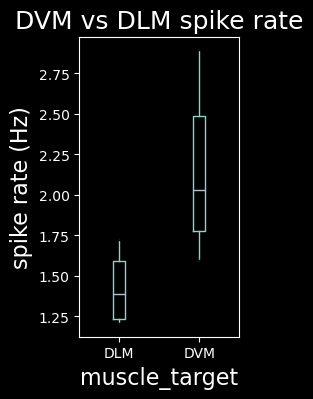

In [61]:
# plot fly-level data 
fig, ax = plt.subplots(figsize=(2,4))

fly_df_grouped.boxplot(column='spike_rate_mean', by='muscle_target', ax=ax, grid=False)
ax.set_ylabel('spike rate (Hz)')
ax.set_title('DVM vs DLM spike rate')
fig.suptitle('')
if save_flag:
    fig.savefig(os.path.join(save_path, f'{save_name}_spike_rate.png'))

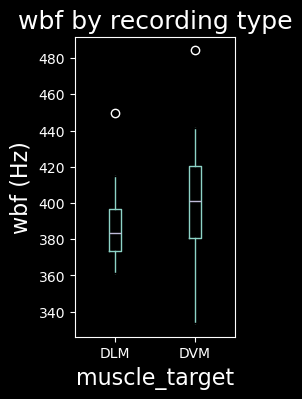

In [62]:
# plot fly-level data 
fig, ax = plt.subplots(figsize=(2,4))

fly_df_grouped.boxplot(column='wbf_mean', by='muscle_target', ax=ax, grid=False)
ax.set_ylabel('wbf (Hz)')
ax.set_title('wbf by recording type')
fig.suptitle('')
if save_flag:
    fig.savefig(os.path.join(save_path,  f'{save_name}_wbf.png'))